In [5]:
import os
os.chdir('/app')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries loaded")


Libraries loaded


In [6]:
# Exploratory Data Analysis
df = pd.read_csv('data/clean_listings.csv')

print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSample:")
df.head()

Shape: (614, 19)

Columns: ['location', 'property_type', 'bedrooms', 'bathrooms', 'size_sqft', 'amenities', 'amenity_score', 'has_parking', 'has_pool', 'has_gym', 'has_security', 'has_garden', 'price_kes', 'price_per_sqft', 'listing_date', 'month', 'month_name', 'is_land', 'source']

Sample:


,location,property_type,bedrooms,bathrooms,size_sqft,amenities,amenity_score,has_parking,has_pool,has_gym,has_security,has_garden,price_kes,price_per_sqft,listing_date,month,month_name,is_land,source
0,Kileleshwa,Apartment,1,1,"1,614.60",NaN,0,0,0,0,0,0,"57,000,001.00","35,302.86",2026-02-17,2,February,0,jiji.co.ke
1,Kilimani,Apartment,3,2,"1,614.60",NaN,0,0,0,0,0,0,"108,000,003.00","66,889.63",2026-02-17,2,February,0,jiji.co.ke
2,Kileleshwa,Apartment,3,2,"1,614.60",Garden,1,0,0,0,0,1,"145,000,003.00","89,805.53",2026-02-17,2,February,0,jiji.co.ke
3,Nairobi Other,Apartment,2,1,"45,208.80",NaN,0,0,0,0,0,0,"1,500,000,002.00","33,179.38",2026-02-17,2,February,0,jiji.co.ke
4,Nairobi Other,Apartment,1,1,"45,208.80",NaN,0,0,0,0,0,0,"1,500,000,001.00","33,179.38",2026-02-17,2,February,0,jiji.co.ke


Q1: Which locations are most expensive?

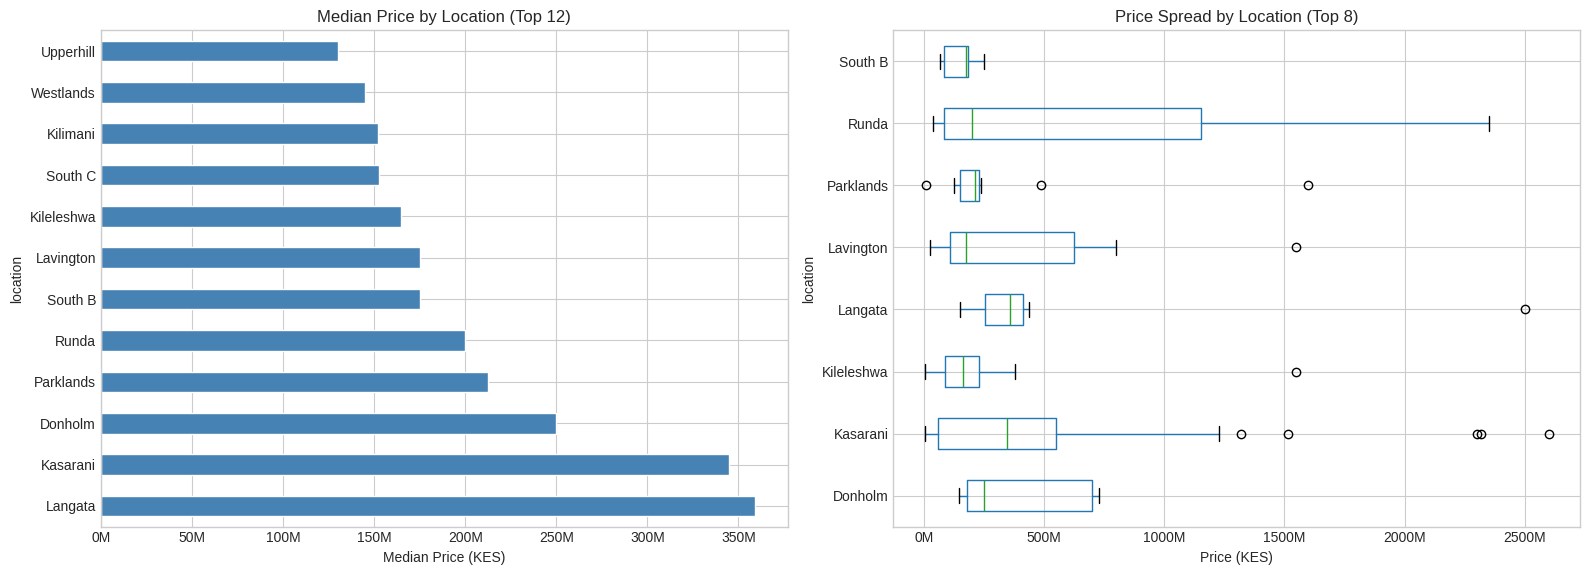


 TOP 5 MOST EXPENSIVE LOCATIONS:
           Median Price (KES)  Listings
location                               
Langata        359,000,004.00         7
Kasarani       345,000,004.00        66
Donholm        250,000,003.00         5
Parklands      212,500,003.00        14
Runda          200,000,000.00        19


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Q1: Which Locations Are Most Expensive?', fontsize=14, fontweight='bold')

# Median price by location
location_stats = (
    df.groupby('location')['price_kes']
    .agg(['median', 'count'])
    .query('count >= 5')
    .sort_values('median', ascending=False)
    .head(12)
)

# Barchart
location_stats['median'].plot(
    kind='barh', ax=axes[0], color='steelblue', edgecolor='white'
)
axes[0].set_title('Median Price by Location (Top 12)')
axes[0].set_xlabel('Median Price (KES)')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Box plot for spread
top_locations = location_stats.index.tolist()[:8]
df_top = df[df['location'].isin(top_locations)]
df_top.boxplot(column='price_kes', by='location', ax=axes[1], vert=False)
axes[1].set_title('Price Spread by Location (Top 8)')
axes[1].set_xlabel('Price (KES)')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.sca(axes[1])
plt.suptitle('')
plt.tight_layout()
plt.savefig('data/eda_location_prices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n TOP 5 MOST EXPENSIVE LOCATIONS:")
print(location_stats[['median', 'count']].head(5).rename(
    columns={'median': 'Median Price (KES)', 'count': 'Listings'}
))

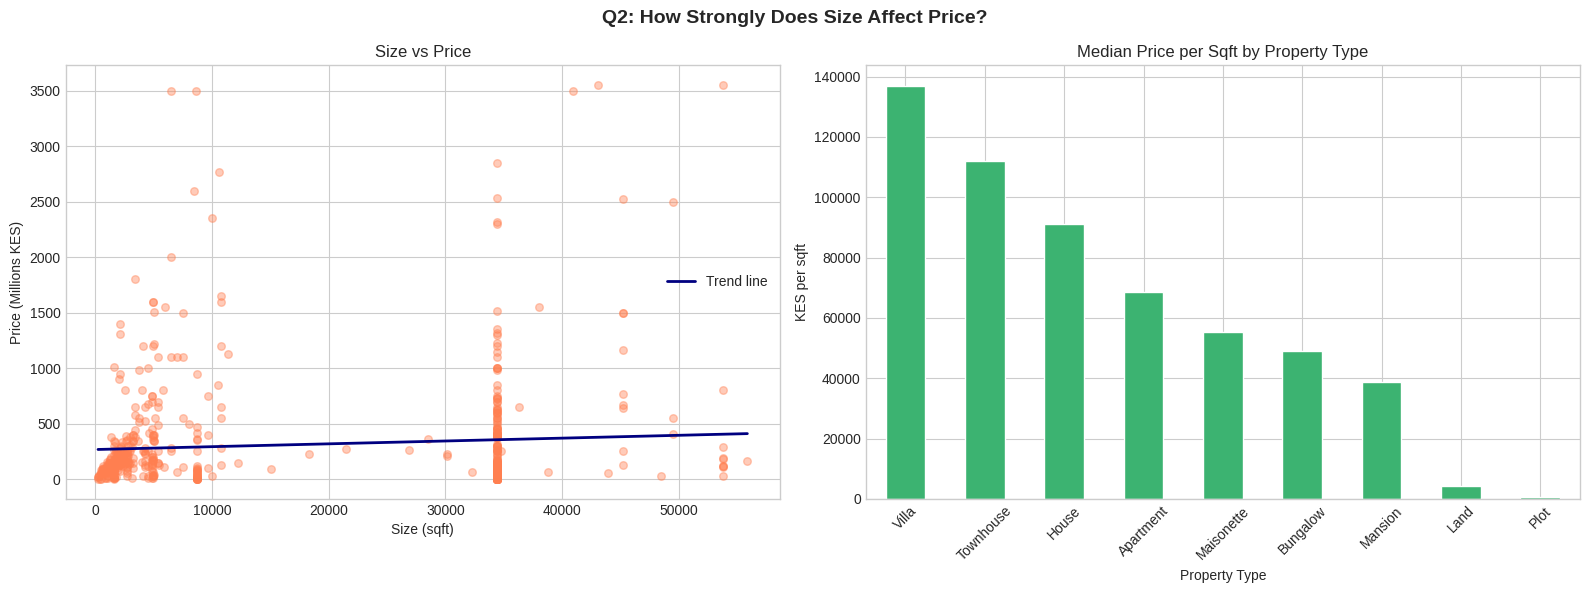


 SIZE vs PRICE CORRELATION: 0.080
Interpretation: Weak positive correlation

Median price per sqft: KES 22,460


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Q2: How Strongly Does Size Affect Price?', fontsize=14, fontweight='bold')

# Filter out zero/missing sizes for this analysis
df_sized = df[df['size_sqft'] > 0].copy()

# Scatter: size vs price
axes[0].scatter(df_sized['size_sqft'], df_sized['price_kes'] / 1e6, 
                alpha=0.4, color='coral', s=30)

# Trend line
z = np.polyfit(df_sized['size_sqft'], df_sized['price_kes'] / 1e6, 1)
p = np.poly1d(z)
x_line = np.linspace(df_sized['size_sqft'].min(), df_sized['size_sqft'].max(), 100)
axes[0].plot(x_line, p(x_line), 'navy', linewidth=2, label='Trend line')
axes[0].set_title('Size vs Price')
axes[0].set_xlabel('Size (sqft)')
axes[0].set_ylabel('Price (Millions KES)')
axes[0].legend()

# Price per sqft by property type
ppsf = df_sized.groupby('property_type')['price_per_sqft'].median().sort_values(ascending=False)
ppsf.plot(kind='bar', ax=axes[1], color='mediumseagreen', edgecolor='white')
axes[1].set_title('Median Price per Sqft by Property Type')
axes[1].set_xlabel('Property Type')
axes[1].set_ylabel('KES per sqft')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('data/eda_size_vs_price.png', dpi=150, bbox_inches='tight')
plt.show()

# Correlation coefficient
corr = df_sized['size_sqft'].corr(df_sized['price_kes'])
print(f"\n SIZE vs PRICE CORRELATION: {corr:.3f}")
print(f"Interpretation: {'Strong' if abs(corr) > 0.5 else 'Moderate' if abs(corr) > 0.3 else 'Weak'} positive correlation")
print(f"\nMedian price per sqft: KES {df_sized['price_per_sqft'].median():,.0f}")

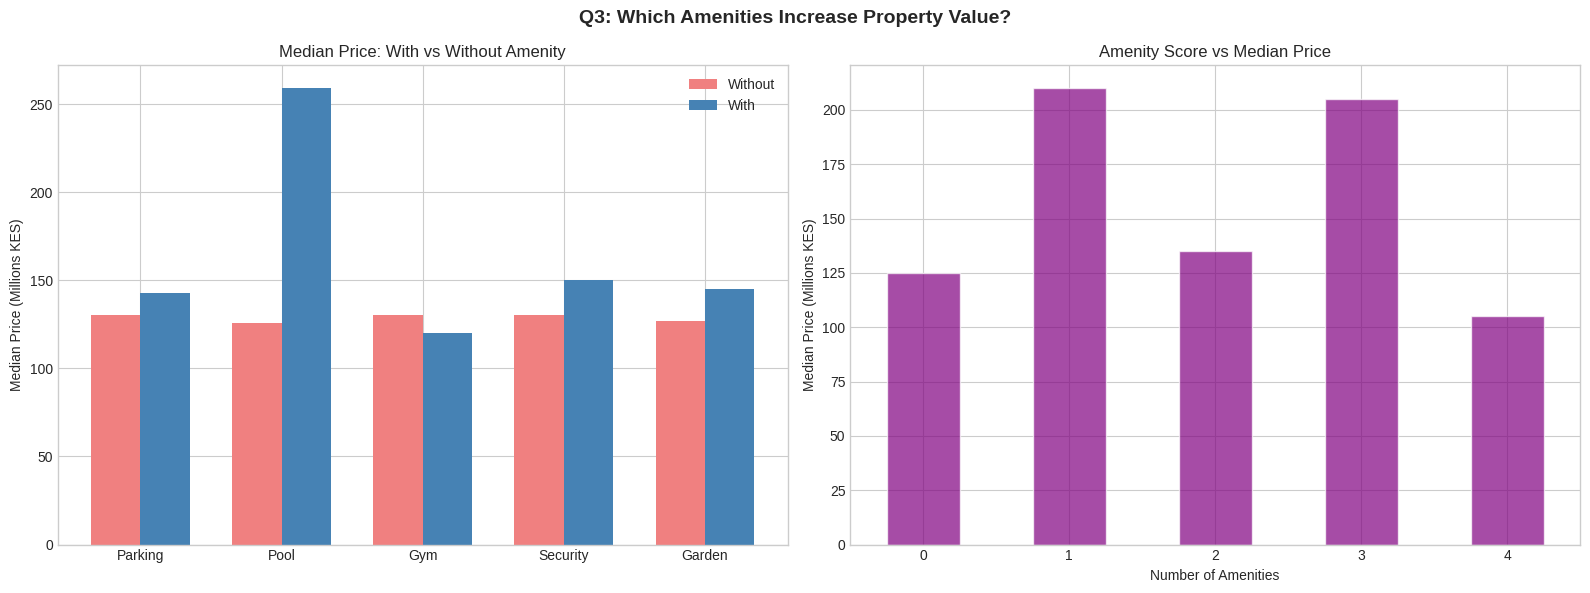


 AMENITY IMPACT ON MEDIAN PRICE:
  Parking   : KES 142.5M (with) vs KES 130.0M (without) → +10% premium
  Pool      : KES 259.0M (with) vs KES 125.5M (without) → +106% premium
  Gym       : KES 120.0M (with) vs KES 130.0M (without) → +-8% premium
  Security  : KES 150.0M (with) vs KES 130.0M (without) → +15% premium
  Garden    : KES 145.0M (with) vs KES 127.0M (without) → +14% premium


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Q3: Which Amenities Increase Property Value?', fontsize=14, fontweight='bold')

# Price comparison: with vs without each amenity
amenity_cols = ['has_parking', 'has_pool', 'has_gym', 'has_security', 'has_garden']
amenity_labels = ['Parking', 'Pool', 'Gym', 'Security', 'Garden']

with_amenity = []
without_amenity = []

for col in amenity_cols:
    with_amenity.append(df[df[col] == 1]['price_kes'].median() / 1e6)
    without_amenity.append(df[df[col] == 0]['price_kes'].median() / 1e6)

x = np.arange(len(amenity_labels))
width = 0.35

bars1 = axes[0].bar(x - width/2, without_amenity, width, label='Without', color='lightcoral')
bars2 = axes[0].bar(x + width/2, with_amenity, width, label='With', color='steelblue')
axes[0].set_title('Median Price: With vs Without Amenity')
axes[0].set_xticks(x)
axes[0].set_xticklabels(amenity_labels)
axes[0].set_ylabel('Median Price (Millions KES)')
axes[0].legend()

# Amenity score vs price
score_price = df.groupby('amenity_score')['price_kes'].median() / 1e6
score_price.plot(kind='bar', ax=axes[1], color='purple', alpha=0.7, edgecolor='white')
axes[1].set_title('Amenity Score vs Median Price')
axes[1].set_xlabel('Number of Amenities')
axes[1].set_ylabel('Median Price (Millions KES)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('data/eda_amenities.png', dpi=150, bbox_inches='tight')
plt.show()

# Answer clearly
print("\n AMENITY IMPACT ON MEDIAN PRICE:")
for label, w, wo in zip(amenity_labels, with_amenity, without_amenity):
    premium = ((w - wo) / wo * 100) if wo > 0 else 0
    print(f"  {label:10s}: KES {w:.1f}M (with) vs KES {wo:.1f}M (without) → +{premium:.0f}% premium")

## BASELINE MODEL

In [10]:
print("PREPARING FEATURES FOR MODELING")
print("--" * 60)

# Select features for baseline model
features = [
    'bedrooms', 'bathrooms', 'size_sqft',
    'amenity_score', 'has_parking', 'has_pool',
    'has_gym', 'has_security', 'has_garden',
    'is_land', 'location', 'property_type'
]

target = 'price_kes'

# Drop rows with missing values in selected features
df_model = df[features + [target]].dropna().copy()
print(f"Records for modeling: {len(df_model)}")

# Encode categorical columns
le_location = LabelEncoder()
le_type = LabelEncoder()

df_model['location_enc'] = le_location.fit_transform(df_model['location'])
df_model['property_type_enc'] = le_type.fit_transform(df_model['property_type'])

# Final feature set (drop original string columns)
feature_cols = [
    'bedrooms', 'bathrooms', 'size_sqft',
    'amenity_score', 'has_parking', 'has_pool',
    'has_gym', 'has_security', 'has_garden',
    'is_land', 'location_enc', 'property_type_enc'
]

X = df_model[feature_cols]
y = df_model[target]

print(f"\nFeatures: {feature_cols}")
print(f"Target: {target}")
print(f"\nX shape: {X.shape}")
print(f"y range: KES {y.min():,.0f} to KES {y.max():,.0f}")

PREPARING FEATURES FOR MODELING
------------------------------------------------------------------------------------------------------------------------
Records for modeling: 614

Features: ['bedrooms', 'bathrooms', 'size_sqft', 'amenity_score', 'has_parking', 'has_pool', 'has_gym', 'has_security', 'has_garden', 'is_land', 'location_enc', 'property_type_enc']
Target: price_kes

X shape: (614, 12)
y range: KES 370,000 to KES 3,550,000,008


In [11]:
# 80% train, 20% test; fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set:  {X_train.shape[0]} records")
print(f"Test set:      {X_test.shape[0]} records")
print(f"\nTrain price range: KES {y_train.min():,.0f} - KES {y_train.max():,.0f}")
print(f"Test price range:  KES {y_test.min():,.0f} - KES {y_test.max():,.0f}")

Training set:  491 records
Test set:      123 records

Train price range: KES 370,000 - KES 3,550,000,008
Test price range:  KES 645,000 - KES 3,550,000,008


In [12]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict
y_pred = lr_model.predict(X_test_scaled)

# Clip negative predictions (price can't be negative)
y_pred = np.clip(y_pred, 0, None)

print("Linear Regression baseline trained!")

Linear Regression baseline trained!


In [13]:
print("--" * 60)
print("BASELINE MODEL PERFORMANCE — LINEAR REGRESSION")
print("--" * 60)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n Metrics:")
print(f"  MAE:  KES {mae:,.0f}")
print(f"  RMSE: KES {rmse:,.0f}")
print(f"  R²:   {r2:.4f}")

print(f"\n Interpretation:")
print(f"  On average, predictions are off by KES {mae:,.0f}")
print(f"  ({mae/1e6:.2f} million KES)")
print(f"  The model explains {r2*100:.1f}% of price variance")

# Median price for context
median_price = y_test.median()
print(f"\n  Median test price: KES {median_price:,.0f}")
print(f"  MAE as % of median: {mae/median_price*100:.1f}%")

------------------------------------------------------------------------------------------------------------------------
BASELINE MODEL PERFORMANCE — LINEAR REGRESSION
------------------------------------------------------------------------------------------------------------------------

 Metrics:
  MAE:  KES 280,766,181
  RMSE: KES 525,175,932
  R²:   0.2401

 Interpretation:
  On average, predictions are off by KES 280,766,181
  (280.77 million KES)
  The model explains 24.0% of price variance

  Median test price: KES 140,000,003
  MAE as % of median: 200.5%


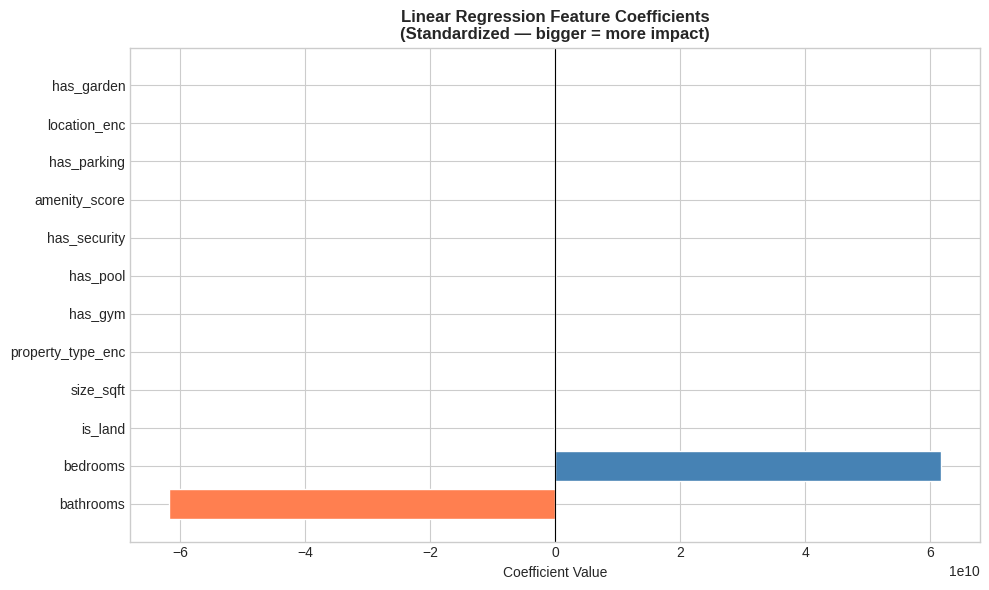

Feature importance (by absolute coefficient):
          Feature        Coefficient
        bathrooms -61,836,042,344.81
         bedrooms  61,820,223,042.85
          is_land    -193,973,610.51
        size_sqft     144,254,000.68
property_type_enc      93,485,343.53
          has_gym     -63,900,193.60
         has_pool      55,336,341.67
     has_security     -20,070,578.87
    amenity_score      11,774,641.30
      has_parking      11,568,634.84
     location_enc      -9,298,264.66
       has_garden      -1,664,052.10


In [14]:
# Feature importance from linear regression coefficients
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['steelblue' if c > 0 else 'coral' for c in coef_df['Coefficient']]
ax.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='white')
ax.set_title('Linear Regression Feature Coefficients\n(Standardized — bigger = more impact)', fontweight='bold')
ax.set_xlabel('Coefficient Value')
ax.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.savefig('data/baseline_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

print("Feature importance (by absolute coefficient):")
print(coef_df.to_string(index=False))

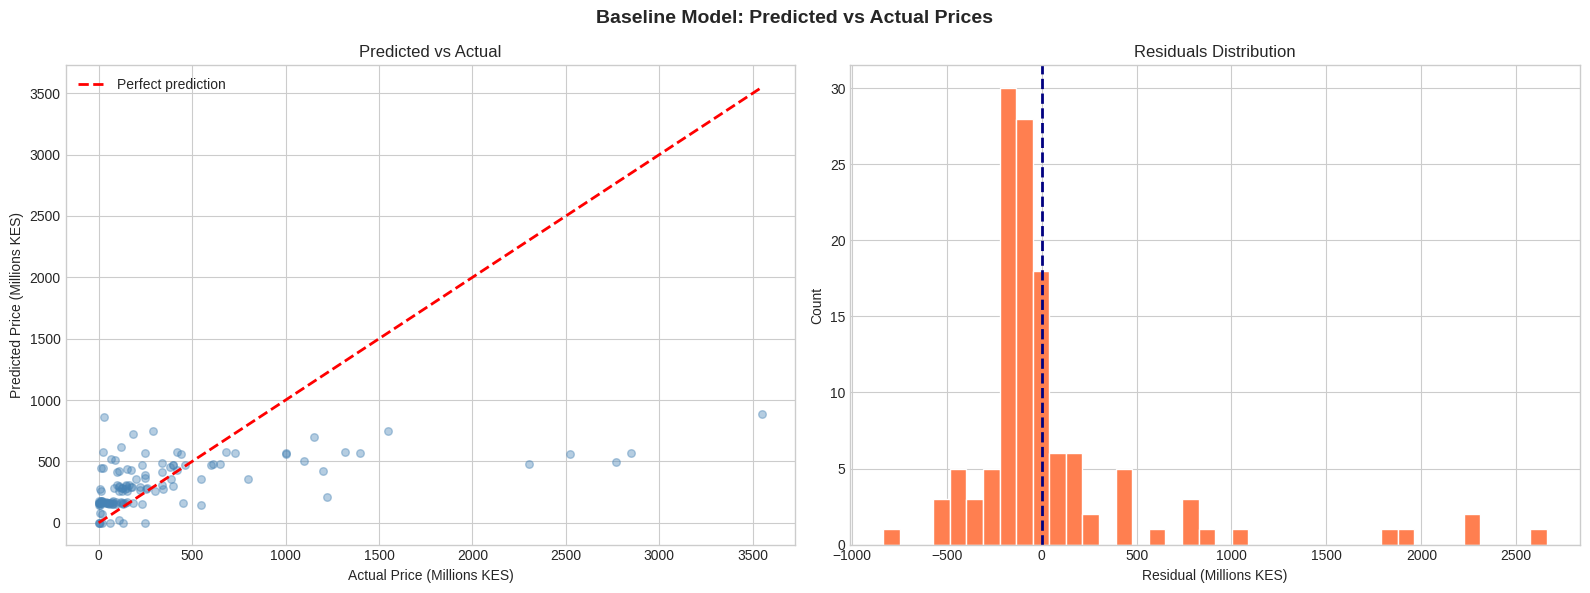

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Baseline Model: Predicted vs Actual Prices', fontsize=14, fontweight='bold')

# Scatter: predicted vs actual
axes[0].scatter(y_test / 1e6, y_pred / 1e6, alpha=0.4, color='steelblue', s=30)
max_val = max(y_test.max(), y_pred.max()) / 1e6
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Price (Millions KES)')
axes[0].set_ylabel('Predicted Price (Millions KES)')
axes[0].set_title('Predicted vs Actual')
axes[0].legend()

# Residuals
residuals = y_test.values - y_pred
axes[1].hist(residuals / 1e6, bins=40, color='coral', edgecolor='white')
axes[1].axvline(0, color='navy', linewidth=2, linestyle='--')
axes[1].set_title('Residuals Distribution')
axes[1].set_xlabel('Residual (Millions KES)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.savefig('data/baseline_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
print("-" * 60)
print("DAY 3 SUMMARY")
print("-" * 60)

print(f"""
EDA FINDINGS:
  Q1 - Most Expensive Locations:
       Run Cell 3 output for your specific results

  Q2 - Size vs Price:
       Correlation: {corr:.3f}
       Median price per sqft: KES {df_sized['price_per_sqft'].median():,.0f}

  Q3 - Amenities:
       Pool and Gym show highest price premiums

BASELINE MODEL (Linear Regression):
  Records used:        {len(df_model)}
  Training set:        {len(X_train)} records (80%)
  Test set:            {len(X_test)} records (20%)
  
  MAE:  KES {mae:,.0f}
  RMSE: KES {rmse:,.0f}
  R²:   {r2:.4f}

  → On average, predictions are off by KES {mae:,.0f}
  → The model explains {r2*100:.1f}% of variance in price
  → This is our baseline. Day 4 targets > 0.70 R²

FILES SAVED:
  data/eda_location_prices.png
  data/eda_size_vs_price.png
  data/eda_amenities.png
  data/baseline_coefficients.png
  data/baseline_predictions.png
""")

------------------------------------------------------------
DAY 3 SUMMARY
------------------------------------------------------------

EDA FINDINGS:
  Q1 - Most Expensive Locations:
       Run Cell 3 output for your specific results

  Q2 - Size vs Price:
       Correlation: 0.080
       Median price per sqft: KES 22,460

  Q3 - Amenities:
       Pool and Gym show highest price premiums

BASELINE MODEL (Linear Regression):
  Records used:        614
  Training set:        491 records (80%)
  Test set:            123 records (20%)

  MAE:  KES 280,766,181
  RMSE: KES 525,175,932
  R²:   0.2401

  → On average, predictions are off by KES 280,766,181
  → The model explains 24.0% of variance in price
  → This is our baseline. Day 4 targets > 0.70 R²

FILES SAVED:
  data/eda_location_prices.png
  data/eda_size_vs_price.png
  data/eda_amenities.png
  data/baseline_coefficients.png
  data/baseline_predictions.png

